<a href="https://colab.research.google.com/github/cbevis/2015lab1/blob/master/311_Capstone_Neural_Net_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 311 Neural Networks 

Rev1 Notes: 
 - Layers early in the network architecture (i.e., closer to the actual input image) learn fewer convolutional filters while layers deeper in the network (i.e., closer to the output predictions) will learn more filters.
https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

- Added ROC curves

### References:
- Convert to grayscale: https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python/12201744#12201744
- Keras early stopping: https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
- Grayscale Keras: https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/
- Combining models: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
- Neighborhoods geojson: https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4
- Plotting in folium: https://towardsdatascience.com/visualizing-data-at-the-zip-code-level-with-folium-d07ac983db2



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import keras
import glob
from PIL import Image

# Import Components for model building
# Import various components for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers import concatenate, Input
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Import the backend
from keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

% matplotlib inline

Using TensorFlow backend.


In [2]:
# Check for GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:

!ls "/content/drive/My Drive/Colab Notebooks"

311-Capstone-Neural-Net-Copy1.ipynb  bw_pickles  Untitled0.ipynb


In [6]:
# Using the first 60000 data points
# Limited due to computational time and disc space
files = glob.glob('/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_[0-9]*.gzde')
print(files)
dim1, dim2, dim3 = 128, 128, 1

df = pd.concat([pd.read_pickle(fp, compression='gzip') for fp in files])

columns = list(df.columns)
columns = [column.lower().replace(' ', '_') for column in columns]
df.columns = columns

# Drop files without an image
df.dropna(subset=['image'], inplace=True)
df['updated'] = pd.to_datetime(df['updated'])
df['opened'] = pd.to_datetime(df['opened'])
df['closed'] = pd.to_datetime(df['closed'])
df['month'] = df['month'].astype('int16')
df['year'] = df['year'].astype('int16')
df['caseid'] = df['caseid'].astype('int')
df['neighborhood'] = df['neighborhood'].astype('category')
df['police_district'] = df['police_district'].astype('category')
df['street'] = df['street'].astype('category')
df['category'] = df['category'].astype('category')
df['status'] = df['status'].astype('category')
df['responsible_agency'] = df['responsible_agency'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('str')
df['street'] = df['street'].astype('str')  

['/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_19000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_26000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_36000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_2000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_44000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_54000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_107000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_117000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_62000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_72000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_10000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_86000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_96000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_73000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pi

In [0]:
df.sort_index(inplace=True)
X_flat = np.concatenate(df.image.values.tolist(), axis=0)
X_flat = X_flat.reshape(df.shape[0], dim1*dim2*dim3) 
df.drop(columns=['image'], inplace=True)

In [0]:
# The shape isn't quite right
X_image.shape

(15266048, 128)

In [0]:
X_image = X_image.reshape(df.shape[0], dim1, dim2, dim3)
X_image.shape

(119266, 128, 128, 1)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119266 entries, 0 to 119999
Data columns (total 22 columns):
caseid                 119266 non-null int64
opened                 119266 non-null datetime64[ns]
closed                 116982 non-null datetime64[ns]
updated                119266 non-null datetime64[ns]
status                 119266 non-null category
status_notes           77189 non-null object
responsible_agency     119266 non-null category
category               119266 non-null category
request_type           119266 non-null object
request_details        117100 non-null object
address                119266 non-null object
street                 119266 non-null object
supervisor_district    119260 non-null float64
neighborhood           119266 non-null object
police_district        118996 non-null category
latitude               119266 non-null float64
longitude              119266 non-null float64
point                  119266 non-null object
source                 11926

In [0]:
df.head(2)

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,neighborhood,police_district,latitude,longitude,point,source,media_url,year,month,image
0,7228536,2017-06-06 07:31:38,2017-06-10 12:26:23,2017-06-10 12:26:23,Closed,SES Graffiti Crew - Paint - Box - Sub Panel -...,DPW Ops Queue,Graffiti,Graffiti on Signal_box,Signal_box - Not_Offensive,...,South of Market,SOUTHERN,37.774734,-122.400620,"(37.7747345, -122.40061951)",Mobile/Open311,http://mobile311.sfgov.org/reports/7228536/photos,2017,6,"[[235, 231, 231, 232, 232, 232, 232, 232, 230,..."
1,9848318,2018-11-25 13:15:00,2018-11-25 14:04:15,2018-11-25 14:04:15,Closed,Officer responded to request under CAD # 18329...,Parking Enforcement Dispatch Queue,Parking Enforcement,Other_Illegal_Parking,Silver - Civic - 5xcs051,...,Tenderloin,TENDERLOIN,37.783645,-122.410763,"(37.78364452, -122.41076323)",Mobile/Open311,http://mobile311.sfgov.org/reports/9848318/photos,2018,11,"[[49, 48, 49, 49, 49, 48, 51, 50, 47, 51, 49, ..."


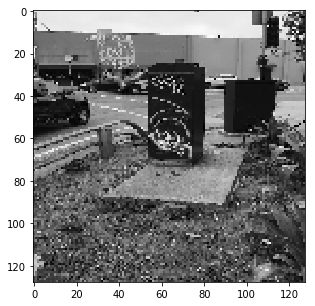

In [0]:
plt.figure(figsize=(5, 5))
plt.imshow(X_image[0].reshape(128, 128), cmap='gray')
plt.show()

In [0]:
X_image[0].shape

(128, 128, 1)

In [0]:
def categorize(df):
    if df['category'] == 'Street and Sidewalk Cleaning':
        if (df['request_type'] == 'Transit_shelter_platform' or
            df['request_type'] == 'Missed_Route_Mechanical_Sweeping'):
            return 'General Cleaning'
        elif df['request_type'] == 'City_garbage_can_overflowing':
            return 'Litter Receptacles'
        elif (df['request_type'] == 'Human Waste' or
              df['request_type'] == 'Medical Waste'):
            return 'Human or Medical Waste'
        elif df['request_type'] == 'Automotive':
            return 'Vehicle'
        else:
            return df['request_type']
    elif ('General' in df['category']) or ('Catch Basin' in df['category']):
        return 'Other'
    elif ((df['category'] == 'Street Defects') or 
          (df['category'] == 'Sidewalk or Curb') or 
          (df['category'] == 'Blocked Street or SideWalk')):
        return 'Street and Sidewalk Issues'
    elif ((df['category'] == 'Abandoned Vehicle') or 
          (df['category'] == 'Parking Enforcement')):
        return 'Vehicle'
    elif (df['category'] == 'Illegal Postings' or
          df['category'] == 'Sign Repair'):
        return 'Signs - Illegal Postings and Repair'
    else:
        return df['category']

In [10]:
df['group'] = df.apply(categorize, axis=1)
print(df['group'].unique())
print(df['group'].nunique())

['Graffiti' 'Vehicle' 'General Cleaning' 'Litter Receptacles'
 'Hazardous Materials' 'Street and Sidewalk Issues'
 'Rec and Park Requests' 'Bulky Items' 'Encampments'
 'Human or Medical Waste' 'Other' 'Signs - Illegal Postings and Repair'
 'Tree Maintenance' 'Sewer Issues' 'Streetlights' 'Damaged Property']
16


In [0]:
df.category.unique()

[Graffiti, Parking Enforcement, Street and Sidewalk Cleaning, Litter Receptacles, Blocked Street or SideWalk, ..., General Request - RPD, General Request - SFPD, General Request - ANIMAL CARE CONTROL, General Request - ENTERTAINMENT COMMISSION, General Request - CENTRAL SHOPS]
Length: 29
Categories (29, object): [Graffiti, Parking Enforcement, Street and Sidewalk Cleaning,
                          Litter Receptacles, ..., General Request - SFPD,
                          General Request - ANIMAL CARE CONTROL, General Request - ENTERTAINMENT COMMISSION,
                          General Request - CENTRAL SHOPS]

In [0]:
print(df['category'].unique())
print(df['category'].nunique())

[Graffiti, Parking Enforcement, Street and Sidewalk Cleaning, Litter Receptacles, Blocked Street or SideWalk, ..., General Request - RPD, General Request - SFPD, General Request - ANIMAL CARE CONTROL, General Request - ENTERTAINMENT COMMISSION, General Request - CENTRAL SHOPS]
Length: 29
Categories (29, object): [Graffiti, Parking Enforcement, Street and Sidewalk Cleaning,
                          Litter Receptacles, ..., General Request - SFPD,
                          General Request - ANIMAL CARE CONTROL, General Request - ENTERTAINMENT COMMISSION,
                          General Request - CENTRAL SHOPS]
29


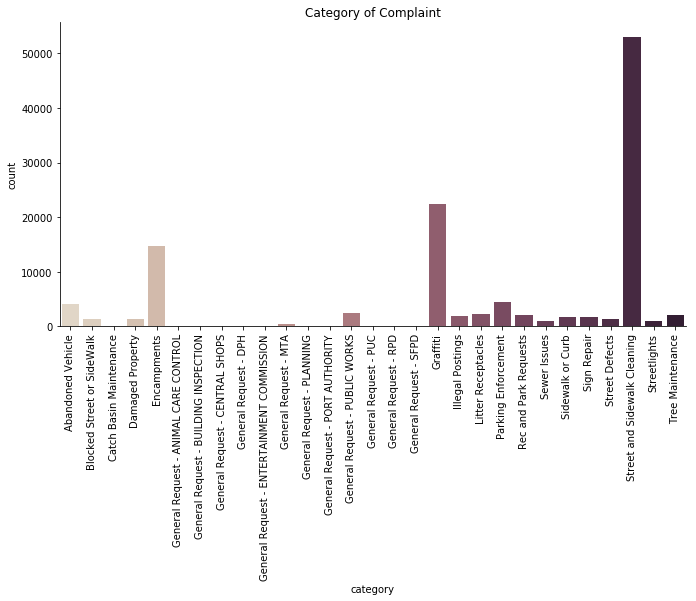

In [0]:
sns.catplot(x='category', 
            kind='count', 
            palette="ch:.25", 
            height=5, 
            aspect=2, 
            data=df)
sns.set(rc={'figure.figsize':(10,20)})
plt.xticks(rotation=90)
plt.title('Category of Complaint')
plt.show()

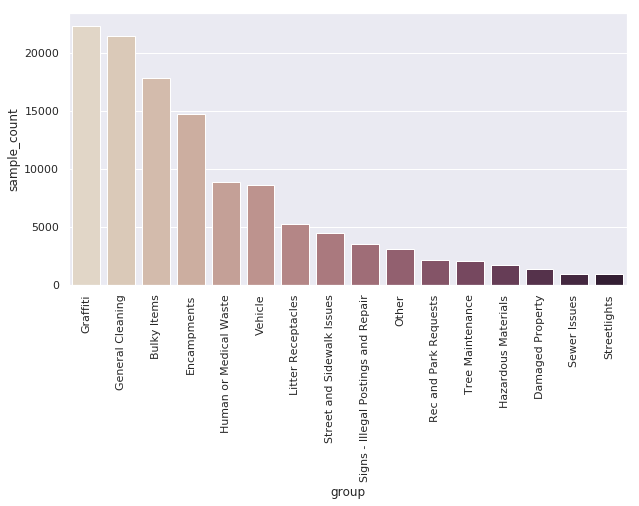

In [0]:
requested = df.groupby('group').count()['caseid'].sort_values(ascending=False).reset_index()
requested.columns = ['group', 'sample_count']

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='group', 
            y='sample_count', 
            palette="ch:.25",
            ax=ax,
            data=requested)
plt.xticks(rotation=90)
plt.show()

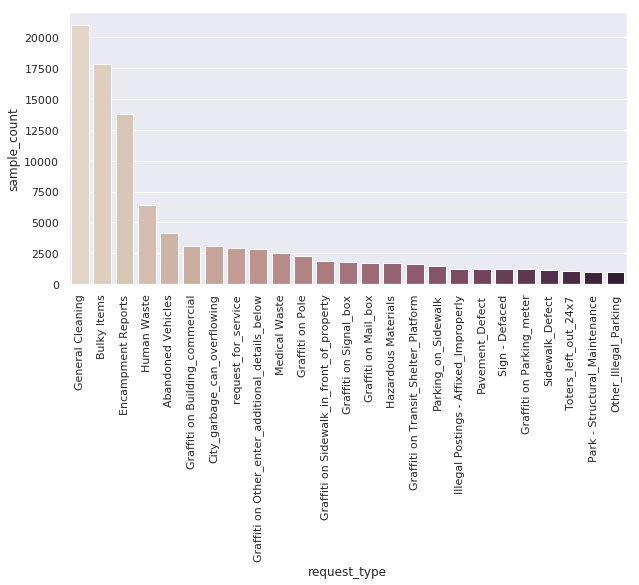

In [0]:
requested = df.groupby('request_type').count()['caseid'].sort_values(ascending=False)[0:25].reset_index()
requested.columns = ['request_type', 'sample_count']
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='request_type', 
                 y='sample_count', 
                 palette="ch:.25", 
                 data=requested)
plt.xticks(rotation=90)
plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, 
                                                    df['group'], 
                                                    test_size=0.25,
                                                    random_state=42)

In [0]:
X_image.shape

(68600, 128, 128, 1)

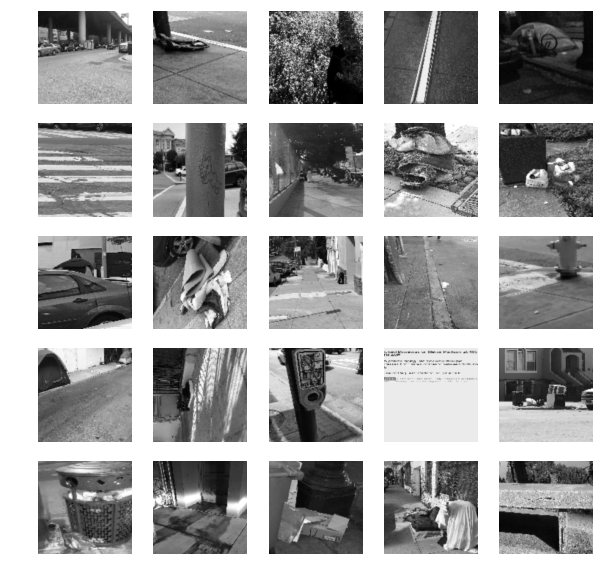

In [0]:
#Visualizing dataset
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_image)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_image[i:i+1][0].reshape(128, 128),
                           cmap='gray',
                           interpolation='gaussian')        

# Multi-Layer Perceptron


In [0]:
# Convert to float32 for type consistency
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize values to 1 from 0 to 255 (256 values of pixels)
X_train /= 255
X_test /= 255

# Print sample sizes
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices
# instead of one column with 10 values, create 29 binary columns
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

y_train = keras.utils.to_categorical(y_train_enc, 16)
y_test = keras.utils.to_categorical(y_test_enc, 16)

51450 train samples
17150 test samples


In [0]:
# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the
# first layer
# Relu is the activation function
model.add(Dense(64, activation='relu', input_shape=(dim1*dim2,)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have
model.add(Dense(16, activation='softmax'))

model.summary()


# Compile the model to put it all together
model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(),
              metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model_MLP.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=20,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1048640   
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                1040      
Total params: 1,053,840
Trainable params: 1,053,840
Non-trainable params: 0
_________________________________________________________________
Train on 51450 samples, validate on 17150 samples
Epoch 1/20
51450/51450 [==============================] - 22s 421us/step - loss: 2

Not amazing considering half are street or sidewalk cleaning

# Convolutional Neural Network
- Black and White 128x128 images

In [11]:
le_group = LabelEncoder()
y_group = le_group.fit_transform(df['group'])

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_flat, 
                                                            df['group'], 
                                                            test_size=0.25,
                                                            random_state=42)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_g)
y_test_enc = le.transform(y_test_g)

y_train_g = keras.utils.to_categorical(y_train_enc, 16)
y_test_g = keras.utils.to_categorical(y_test_enc, 16)

# Convert to float32 for type consistency
X_train_g = X_train_g.astype('float32')
X_test_g = X_test_g.astype('float32')

# Normalize values to 1 from 0 to 255 (256 values of pixels)
X_train_g /= 255
X_test_g /= 255

img_rows, img_cols = 128, 128
input_shape = (img_rows, img_cols, 1)

X_train_g = X_train_g.reshape(X_train_g.shape[0], img_rows, img_cols, 1)
X_test_g = X_test_g.reshape(X_test_g.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
num_classes = 16

print('x_train shape:', X_train_g.shape)
print(X_train_g.shape[0], 'train samples')
print(X_test_g.shape[0], 'test samples')

x_train shape: (89449, 128, 128, 1)
89449 train samples
29817 test samples


In [0]:
y_test_g.shape

In [12]:
# This returns a tensor
inputs = Input(shape=input_shape)
chan_dim = -1

# a layer instance is callable on a tensor, and returns a tensor
x1 = Conv2D(32, (3, 3), padding='same')(inputs)
#x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(64, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(128, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Dropout(0.25)(x1)
x1 = Flatten()(x1)
x1 = Dense(num_classes)(x1)
x1 = Activation('softmax')(x1)

cnn = Model(inputs, x1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
cnn.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy'])

# Set callback functions to early stop training and save 
# the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model_cnn.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = cnn.fit(X_train_g, y_train_g,
                  batch_size=32,
                  epochs=5,
                  verbose=1,
                  callbacks=callbacks,
                  validation_data=(X_test_g, y_test_g))
score = cnn.evaluate(X_test_g, y_test_g, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Train on 89449 samples, validate on 29817 samples
Epoch 1/5
89449/89449 [==============================] - 91s 1ms/step - loss: 2.7958 - acc: 0.2973 - val_loss: 5.7462 - val_acc: 0.1944
Epoch 2/5
89449/89449 [==============================] - 86s 961us/step - loss: 1.9639 - acc: 0.3678 - val_loss: 3.3175 - val_acc: 0.2179
Epoch 3/5
89449/89449 [==============================] - 86s 960us/step - loss: 1.8943 - acc: 0.3878 - val_loss: 2.0875 - val_acc: 0.3563
Epoch 4/5
89449/89449 [==============================] - 86s 962us/step - loss: 1.8532 - acc: 0.4035 - val_loss: 1.9922 - val_acc: 0.3776
Epoch 5/5
89449/89449 [==============================] - 86s 961us/step - loss: 1.8049 - acc: 0.4172 - val_loss: 1.9866 - val_acc: 0.3751
Test loss: 1.9865938693691787
Test accuracy: 0.3751215749344732


In [0]:
y_pred = cnn.predict(X_test_g)  
#y_pred_labels = np.argmax(y_pred, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

#confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)  

In [15]:
y_pred.shape

(29817, 16)

In [0]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_conf = np.argmax(y_test_g, axis=1)
confusion_matrix = confusion_matrix(y_true=y_test_conf, y_pred=y_pred_labels)  

In [17]:
print(confusion_matrix)

[[1829    0  515  542 1050    0   89  107    0    1    0    6    4    2
    15  323]
 [  60    0   17   28  161    0   16    9    0    0    0    0    2    0
     5   25]
 [ 620    0 1493  281  894    0   41   54    0    0    0   18    3    8
    27  299]
 [1413    0  644 1575 1008    0  204  119    0    3    0    6    7    5
    53  249]
 [ 532    0  244  189 4027    0  165   50    0    3    0   67    6    6
    14  220]
 [  97    0   14  103   88    0   84    2    0    0    0    0    3    0
     1   17]
 [ 410    0  159  450  492    0  593   19    0    7    0    0   23    0
    21   48]
 [ 264    0  121  159  409    0   10  288    0    0    0    5    2    1
     5   98]
 [ 132    0  159   95  255    0   36   11    0    1    0    4    1    1
    15   70]
 [  58    0   48   80  207    0   36   13    0    7    0    5    5    1
    13   54]
 [  38    0    9   52   75    0   32    5    0    0    0    1    0    2
     5    9]
 [  40    0   56   11  627    0    5    2    0    0    0   87    

In [0]:
print(le_group.inverse_transform(range(0, 16)))
print(le_group.inverse_transform([1, 5, 6, 7, 8, 10, 11, 13, 14, 15]))
print('classified as:')
print(le_group.inverse_transform([0, 2, 3, 4, 9, 12]))

No predictions for the following: 'Damaged Property' 'Hazardous Materials' 'Human or Medical Waste'
 'Litter Receptacles' 'Other' 'Sewer Issues'
 'Signs - Illegal Postings and Repair' 'Streetlights' 'Tree Maintenance'
 'Vehicle']

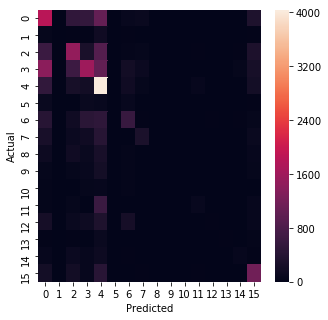

In [18]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [0]:
new_others = list(le_group.inverse_transform([1, 5, 6, 7, 8, 10, 11, 13, 14, 15]))

In [0]:
new_others

In [0]:
df['group2'] = df['group']
df['group2'] = df['group2'].replace(to_replace=new_others, value='Other')
print(df['group2'].nunique())

In [0]:
df.head()

# Model for Categorical Variables - Multi Layer Perceptron (MLP)

In [0]:
features = ['month', 'neighborhood', 'street']

In [20]:
# Select features and one hot encode
X_cat = df[features]
ohe = OneHotEncoder()
X_cat = ohe.fit_transform(X_cat)
print('Shapes: \n')
print('X one hot encoded: {}'.format(X_cat.shape))

# Use same y as before, same random_state
X_cat_train, X_cat_test = train_test_split(X_cat, 
                                           test_size=0.25,
                                           random_state=42)


# Select features with variance threshold of 99.95%
# 1 or 0 in more than 99.95% of samples
sel = VarianceThreshold(threshold=(.9995*(1-.9995)))
X_sel_train = sel.fit_transform(X_cat_train)
X_sel_test = sel.transform(X_cat_test)
print('X_train Variance Threshold: {}'.format(X_sel_train.shape))

# Select K Best Features
k_num = X_sel_train.shape[1]
sel_k = SelectKBest(chi2, k=k_num)
X_sel_k = sel_k.fit_transform(X_sel_train, y_train_g)
X_sel_k_test = sel_k.transform(X_sel_test)
print('X_train Select K Best, K={}: {}'.format(k_num, X_sel_k.shape))

Shapes: 

X one hot encoded: (119266, 2068)
X_train Variance Threshold: (89449, 463)
X_train Select K Best, K=463: (89449, 463)


In [21]:
input_shape_cat = X_sel_k.shape[1]

# This returns a tensor
inputs = Input(shape=(input_shape_cat,))

# a layer instance is callable on a tensor and returns a tensor
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(16, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
mlp = Model(inputs=inputs, outputs=predictions)
mlp.compile(loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model_cat.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = mlp.fit(X_sel_k, y_train_g,
                  batch_size=128,
                  epochs=20,
                  verbose=1,
                  callbacks=callbacks,
                  validation_data=(X_sel_k_test, y_test_g))
score = mlp.evaluate(X_sel_k_test, y_test_g, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 89449 samples, validate on 29817 samples
Epoch 1/20
89449/89449 [==============================] - 3s 38us/step - loss: 2.1890 - acc: 0.2734 - val_loss: 2.1077 - val_acc: 0.3042
Epoch 2/20
89449/89449 [==============================] - 3s 35us/step - loss: 2.0911 - acc: 0.3111 - val_loss: 2.0872 - val_acc: 0.3099
Epoch 3/20
89449/89449 [==============================] - 3s 35us/step - loss: 2.0662 - acc: 0.3182 - val_loss: 2.0763 - val_acc: 0.3124
Epoch 4/20
89449/89449 [==============================] - 3s 34us/step - loss: 2.0528 - acc: 0.3224 - val_loss: 2.0706 - val_acc: 0.3165
Epoch 5/20
89449/89449 [==============================] - 3s 35us/step - loss: 2.0409 - acc: 0.3252 - val_loss: 2.0642 - val_acc: 0.3165
Epoch 6/20
89449/89449 [==============================] - 3s 34us/step - loss: 2.0324 - acc: 0.3283 - val_loss: 2.0627 - val_acc: 0.3163
Epoch 7/20
89449/89449 [==============================] - 3s 35us/step - loss: 2.0250 - acc: 0.3302 - val_loss: 2.0585 - val_acc

# Combine Models

In [24]:
# combine the output of previous two models
combined_input = concatenate([mlp.output, cnn.output])

# Final Fully Connected layer head, 2 dense layers
x3 = Dense(32, activation='relu')(combined_input)
x3 = Dropout(0.5)(x3)
x3 = Dense(16, activation='softmax')(x3)
                              
# Final model accepts input from both mlp and cnn
model = Model(inputs=[mlp.input, cnn.input], outputs=x3)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model_all.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = model.fit([X_sel_k, X_train_g], y_train_g,
                     batch_size=32,
                     epochs=20,
                     verbose=1,
                     callbacks=callbacks,
                     validation_data=([X_sel_k_test, X_test_g], y_test_g))
score = model.evaluate([X_sel_k_test, X_test_g], y_test_g, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 89449 samples, validate on 29817 samples
Epoch 1/20
89449/89449 [==============================] - 90s 1ms/step - loss: 2.0967 - acc: 0.3350 - val_loss: 2.1227 - val_acc: 0.3206
Epoch 2/20
89449/89449 [==============================] - 89s 993us/step - loss: 1.8745 - acc: 0.4172 - val_loss: 2.0494 - val_acc: 0.3546
Epoch 3/20
89449/89449 [==============================] - 89s 994us/step - loss: 1.8076 - acc: 0.4370 - val_loss: 1.9092 - val_acc: 0.4114
Epoch 4/20
89449/89449 [==============================] - 90s 1ms/step - loss: 1.7674 - acc: 0.4556 - val_loss: 2.1085 - val_acc: 0.3452
Epoch 5/20
89449/89449 [==============================] - 89s 992us/step - loss: 1.7305 - acc: 0.4736 - val_loss: 1.8908 - val_acc: 0.4246
Epoch 6/20
89449/89449 [==============================] - 88s 987us/step - loss: 1.6975 - acc: 0.4850 - val_loss: 2.0587 - val_acc: 0.3810
Epoch 7/20
89449/89449 [==============================] - 89s 991us/step - loss: 1.6797 - acc: 0.4921 - val_loss: 2.0190

In [0]:
from google.colab import files
files.download('best_model_all.h5')

## ROC Curves
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
Micro Average vs Macro Average: A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. 

In [0]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_g[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

# Plot all ROC curves
plt.figure()
plt.plot(fpr['micro'], tpr['micro'],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc['micro']),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr['macro'], tpr['macro'],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc['macro']),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()